## Soccer Run Clustering

### *Goals*:
- Using the Metrica data (via `kloppy`), cluster 20 different run types that happen during an entire match.
- Apply appropriate normalization. Remember that teams switch sides at halftime.
- Plot the different cluster centers using `mplsoccer`
- Define "runs" as periods in which an individual player spends above a certain velocity of your choosing.

In [1]:
# Install Some Dependancies
!pip install kloppy --quiet
!pip install mplsoccer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.3 MB/s eta 0:00:00


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from kloppy import metrica
from mplsoccer import Pitch

In [4]:
ds = metrica.load_open_data(match_id=1) # This takes 30-60 seconds

In [5]:
pitch_attrs = {
    "pitch_type": "metricasports",
    "pitch_length": ds.metadata.pitch_dimensions.pitch_length,
    "pitch_width": ds.metadata.pitch_dimensions.pitch_width
}

In [6]:
frame_number = 300
frame = ds.frames[frame_number]  # Get a specific frame

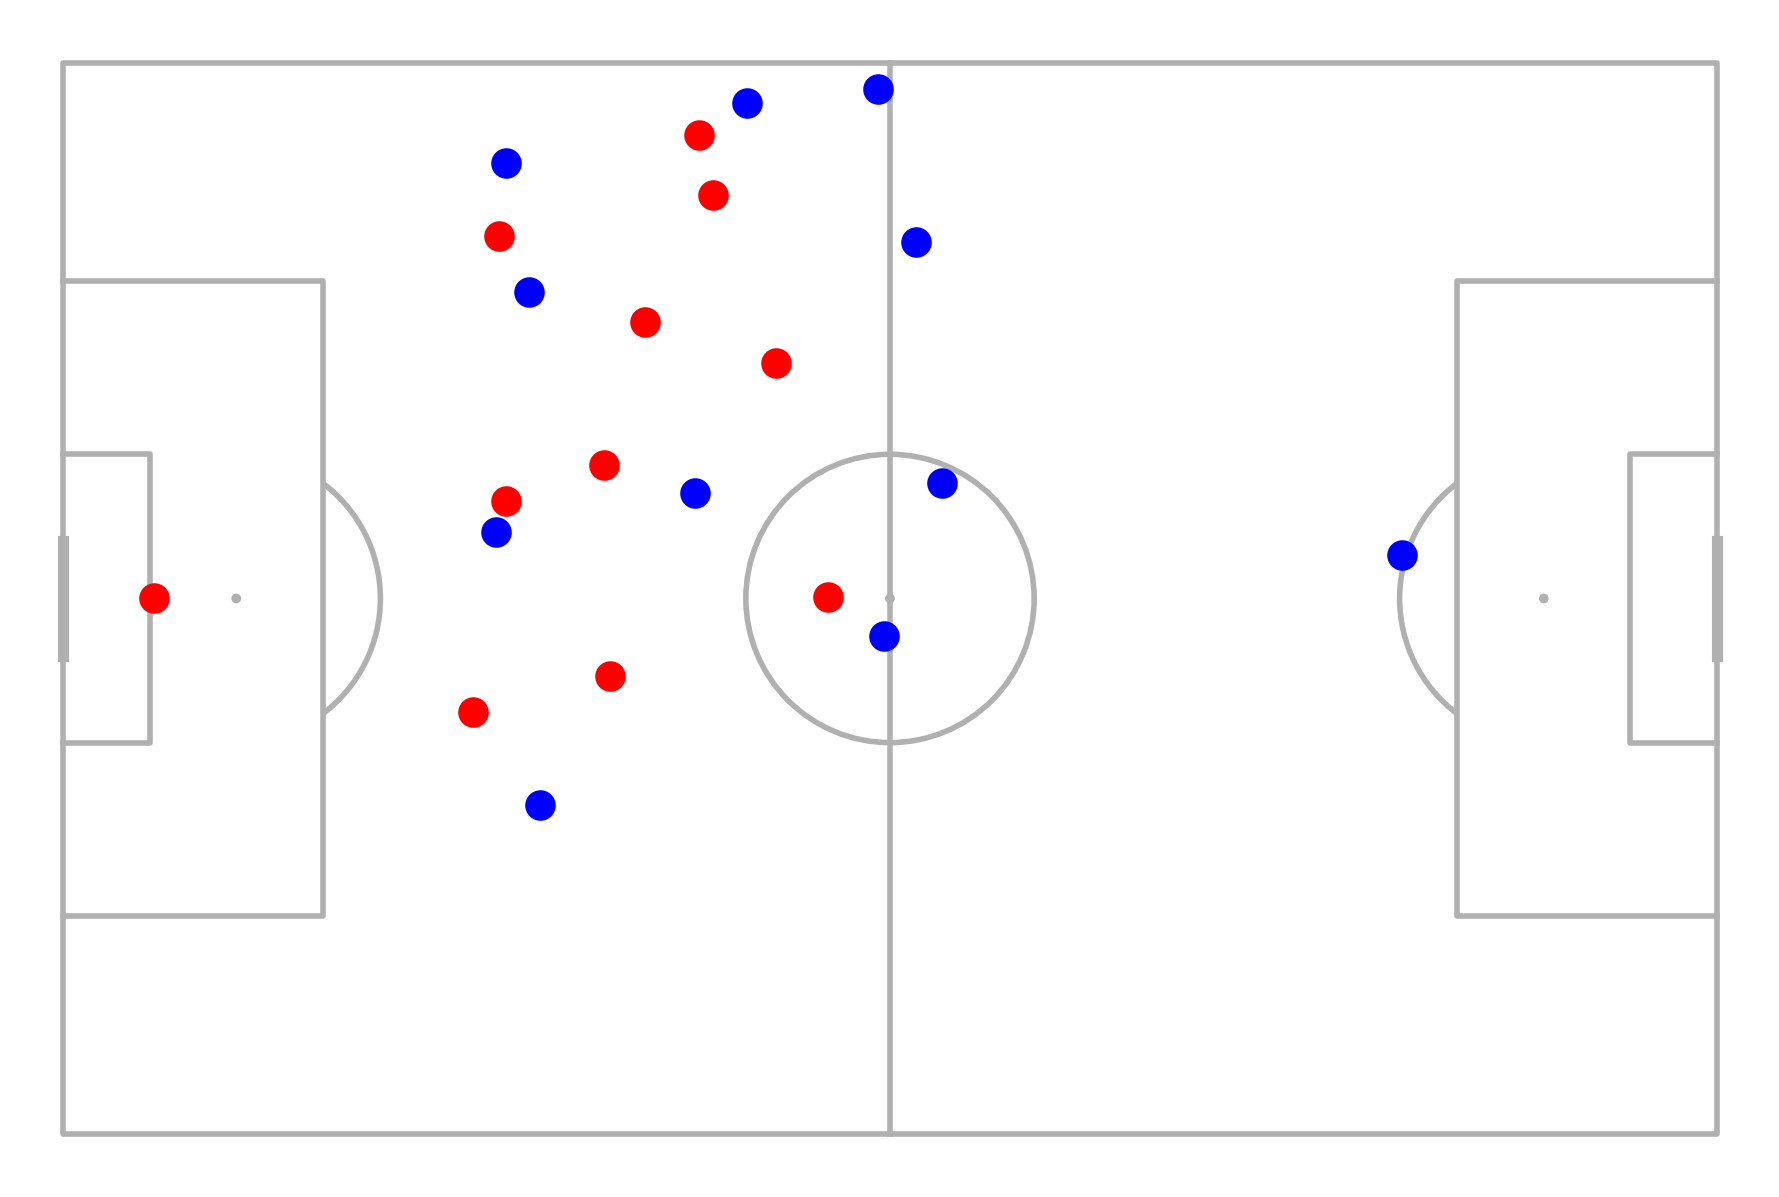

In [7]:
pitch = Pitch(**pitch_attrs)
fig, ax = pitch.draw(figsize=(9,16))

for player, player_data in frame.players_data.items():
    xy = [player_data.coordinates.x, player_data.coordinates.y]
    color = "red" if player.team.name == "Home" else "blue"
    pitch.scatter(*xy, ax=ax, c=color, s=100)

Goals 1 & 2: Using the Metrica data (via kloppy), cluster 20 different run types that happen during an entire match.
Apply appropriate normalization. Remember that teams switch sides at halftime.

In [8]:
# Step 0 – Imports

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from kloppy import metrica
from scipy.spatial.distance import cdist

In [9]:
# Step 1 – Correct for halftime

def correct_for_halftime(df, pitch_length=105, pitch_width=68):
    df = df.copy()
    halftime = df['timestamp'].median()
    mask = df['timestamp'] > halftime

    df.loc[mask, 'x'] = pitch_length - df.loc[mask, 'x']
    df.loc[mask, 'y'] = pitch_width - df.loc[mask, 'y']
    df.loc[mask, 'vx'] *= -1
    df.loc[mask, 'vy'] *= -1
    return df

In [10]:
# Step 2 – Extract runs

def extract_runs(df, vel_threshold=3.9, min_duration=0.5, min_distance=5.0, fps=25, max_speed=12.0):
    df = df.copy()
    df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)
    df.loc[df['speed'] > max_speed, 'speed'] = 0

    runs = []
    for pid, group in df.groupby('player_id'):
        group = group.sort_values('timestamp').reset_index(drop=True)
        is_fast = group['speed'] > vel_threshold
        start = None

        for i, flag in enumerate(is_fast):
            if flag and start is None:
                start = i
            elif not flag and start is not None:
                end = i
                if (end - start) / fps >= min_duration:
                    run = group.iloc[start:end].copy()
                    dx = run['x'].iloc[-1] - run['x'].iloc[0]
                    dy = run['y'].iloc[-1] - run['y'].iloc[0]
                    distance = np.sqrt(dx**2 + dy**2)
                    if distance >= min_distance:
                        run['player_id'] = pid
                        runs.append(run)
                start = None

        if start is not None:
            end = len(group)
            if (end - start) / fps >= min_duration:
                run = group.iloc[start:end].copy()
                dx = run['x'].iloc[-1] - run['x'].iloc[0]
                dy = run['y'].iloc[-1] - run['y'].iloc[0]
                distance = np.sqrt(dx**2 + dy**2)
                if distance >= min_distance:
                    run['player_id'] = pid
                    runs.append(run)
    return runs

In [11]:
# Step 3 – Normalize runs

def normalize_runs(runs, time_steps=50, pitch_length=105, pitch_width=68):
    norm_runs = []
    for run in runs:
        run_copy = run.copy()
        if run_copy['x'].iloc[0] > run_copy['x'].iloc[-1]:
            run_copy['x'] = pitch_length - run_copy['x']
            run_copy['y'] = pitch_width - run_copy['y']

        x = np.interp(np.linspace(0, len(run_copy)-1, time_steps),
                      np.arange(len(run_copy)), run_copy['x'])
        y = np.interp(np.linspace(0, len(run_copy)-1, time_steps),
                      np.arange(len(run_copy)), run_copy['y'])
        norm_runs.append(np.stack([x, y], axis=1))
    return norm_runs

In [12]:
# Step 4 – Runs → Features

def runs_to_features(norm_runs):
    return np.array([run.flatten() for run in norm_runs])

In [13]:
# Step 5 – Clustering

def perform_clustering(features, n_clusters=20):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    pca = PCA(n_components=min(40, scaled.shape[1]))
    reduced = pca.fit_transform(scaled)

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced)

    return labels, kmeans, pca, scaler, reduced

Goal 3 & 4: Plot the different cluster centers using mplsoccer. Define "runs" as periods in which an individual player spends above a certain velocity of your choosing. Explain your selection.

In [14]:
# Step 1 – Plot cluster centroids

def plot_smooth_cluster_centroids(norm_runs, labels, n_clusters=20,
                                  pitch_length=105, pitch_width=68, centroid_color='blue'):

    fig, axs = plt.subplots(5, 4, figsize=(10.5, 6.8))
    axs = axs.flatten()

    for i in range(n_clusters):
        cluster_idx = np.where(labels == i)[0]
        cluster_runs = [norm_runs[j] for j in cluster_idx]

        if len(cluster_runs) == 0:
            axs[i].set_title(f'Cluster {i+1} (0 runs)')
            axs[i].axis('off')
            continue

        run_stack = np.stack(cluster_runs)
        centroid_coords = np.mean(run_stack, axis=0)

        pitch = Pitch(pitch_type='statsbomb', pitch_length=pitch_length, pitch_width=pitch_width)
        pitch.draw(ax=axs[i])

        axs[i].plot(centroid_coords[:, 0], centroid_coords[:, 1],
                    color=centroid_color, lw=2, alpha=0.9)

        axs[i].arrow(centroid_coords[-2, 0], centroid_coords[-2, 1],
                     centroid_coords[-1, 0] - centroid_coords[-2, 0],
                     centroid_coords[-1, 1] - centroid_coords[-2, 1],
                     shape='full', color=centroid_color,
                     lw=2, head_width=1.5, head_length=2.5)

        axs[i].set_title(f'Cluster {i+1} ({len(cluster_runs)} runs)')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

Loading tracking data...
Correcting for halftime...
Extracting runs...
Found 444 runs.
Normalizing runs...
Normalized 444 runs into 100 features each.
Clustering runs...
Clustered into 20 clusters.
Plotting cluster centroids...


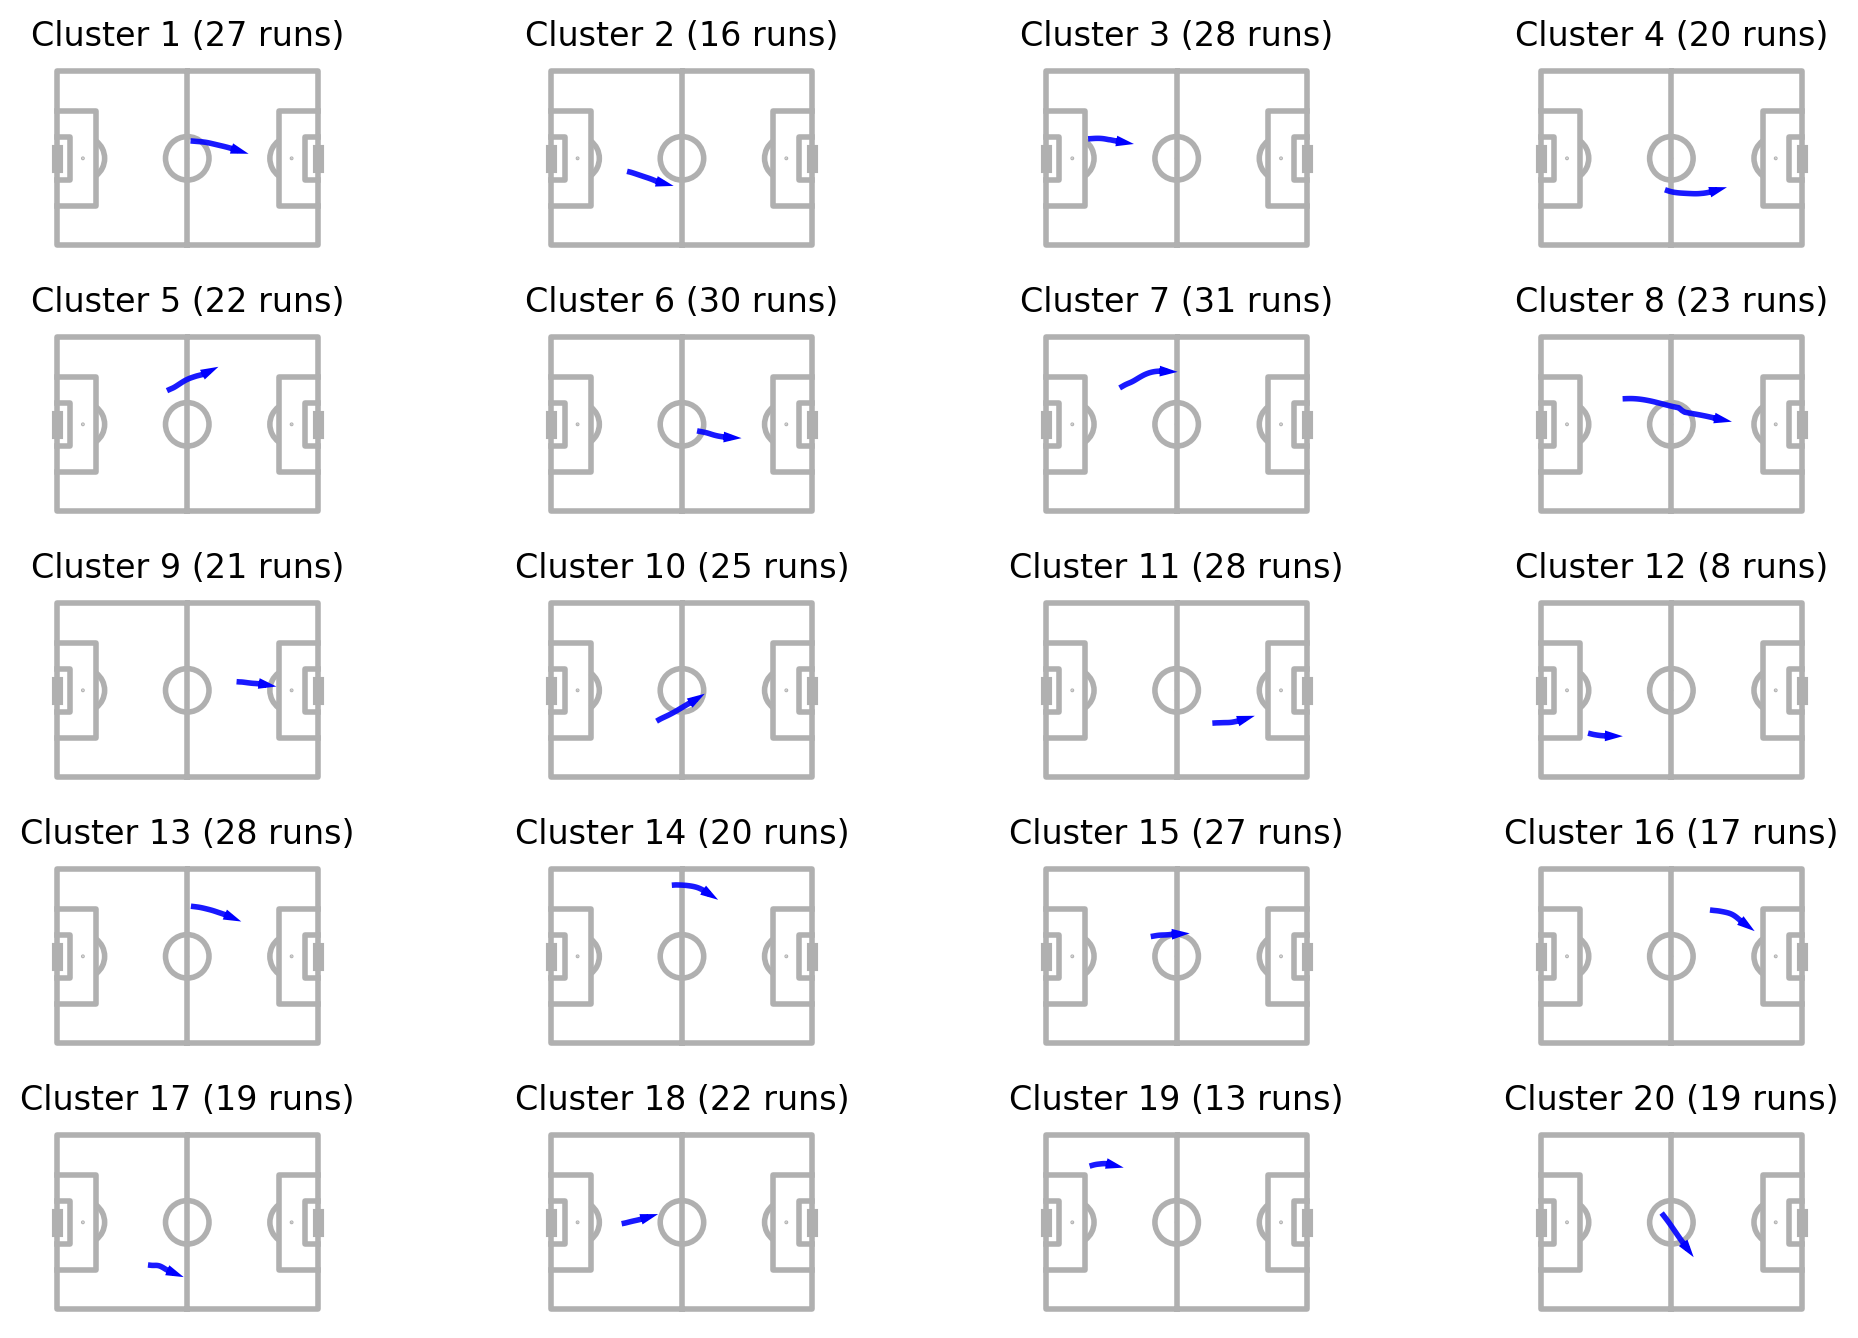

Done.


In [15]:
# Step 2 – Main Execution

print("Loading tracking data...")
ds_tracking = ds

# Convert to DataFrame
all_tracking_data = []
for frame in ds_tracking.frames:
    timestamp = frame.timestamp
    for player_id, player_data in frame.players_data.items():
        if player_data.coordinates:
            all_tracking_data.append({
                'timestamp': timestamp,
                'player_id': player_id.player_id,
                'x': player_data.coordinates.x,
                'y': player_data.coordinates.y
            })

df_tracking = pd.DataFrame(all_tracking_data).sort_values(['player_id', 'timestamp'])

# Convert normalized coordinates to meters
pitch_length = ds_tracking.metadata.pitch_dimensions.pitch_length
pitch_width = ds_tracking.metadata.pitch_dimensions.pitch_width
df_tracking['x'] *= pitch_length
df_tracking['y'] *= pitch_width

# Compute velocities
df_tracking['dt'] = df_tracking.groupby('player_id')['timestamp'].diff().dt.total_seconds()
df_tracking['dx'] = df_tracking.groupby('player_id')['x'].diff()
df_tracking['dy'] = df_tracking.groupby('player_id')['y'].diff()
df_tracking['vx'] = df_tracking['dx'] / df_tracking['dt']
df_tracking['vy'] = df_tracking['dy'] / df_tracking['dt']
df_tracking[['vx', 'vy']] = df_tracking[['vx', 'vy']].fillna(0)

# Halftime correction
print("Correcting for halftime...")
df_tracking = correct_for_halftime(df_tracking, pitch_length=pitch_length, pitch_width=pitch_width)

# ------------------------------------------------------------
# Velocity Threshold Justification
# ------------------------------------------------------------
#
# Runs are defined as continuous periods where a player's velocity
# exceeds 3.9 m/s. This threshold was selected based on the lower
# boundary of *medium-intensity running* reported in de Haan et al. (2025),
# who classified 14 km/h (≈ 3.9 m/s) as the minimum speed representing
# purposeful, match-relevant running actions. This aligns well with
# commonly used thresholds in performance-analysis literature and provides
# a meaningful separation between jogging (< ~3.3 m/s) and true running
# (> ~3.6–4.0 m/s).
#
# Reference:
# de Haan, M., van der Zwaard, S., Sanders, J., Beek, P. J., & Jaspers, R. T. (2025).
# Classifying Soccer Players Based on Physical Capacities and Match-Specific Running
# Performance Using Machine Learning. Journal of Sports Science and Medicine, 24, 764–778.
# https://doi.org/10.52082/jssm.2025.764
# ------------------------------------------------------------

print("Extracting runs...")
VELOCITY_THRESHOLD = 3.9     # justified above
MIN_DURATION = 0.4
MIN_DISTANCE = 5.0

runs = extract_runs(
    df_tracking,
    vel_threshold=VELOCITY_THRESHOLD,
    min_duration=MIN_DURATION,
    min_distance=MIN_DISTANCE
)

print(f"Found {len(runs)} runs.")

# Normalize runs
print("Normalizing runs...")
TIME_STEPS = 50
norm_runs = normalize_runs(
    runs,
    time_steps=TIME_STEPS,
    pitch_length=pitch_length,
    pitch_width=pitch_width
)
features = runs_to_features(norm_runs)

if features.size > 0:
    print(f"Normalized {len(norm_runs)} runs into {features.shape[1]} features each.")
    print("Clustering runs...")

    N_CLUSTERS = 20
    labels, kmeans, pca, scaler, reduced = perform_clustering(features, n_clusters=N_CLUSTERS)
    print(f"Clustered into {N_CLUSTERS} clusters.")

    print("Plotting cluster centroids...")
    plot_smooth_cluster_centroids(
        norm_runs, labels, n_clusters=N_CLUSTERS,
        pitch_length=pitch_length, pitch_width=pitch_width
    )
    print("Done.")
else:
    print("No runs found. Adjust velocity or duration thresholds.")


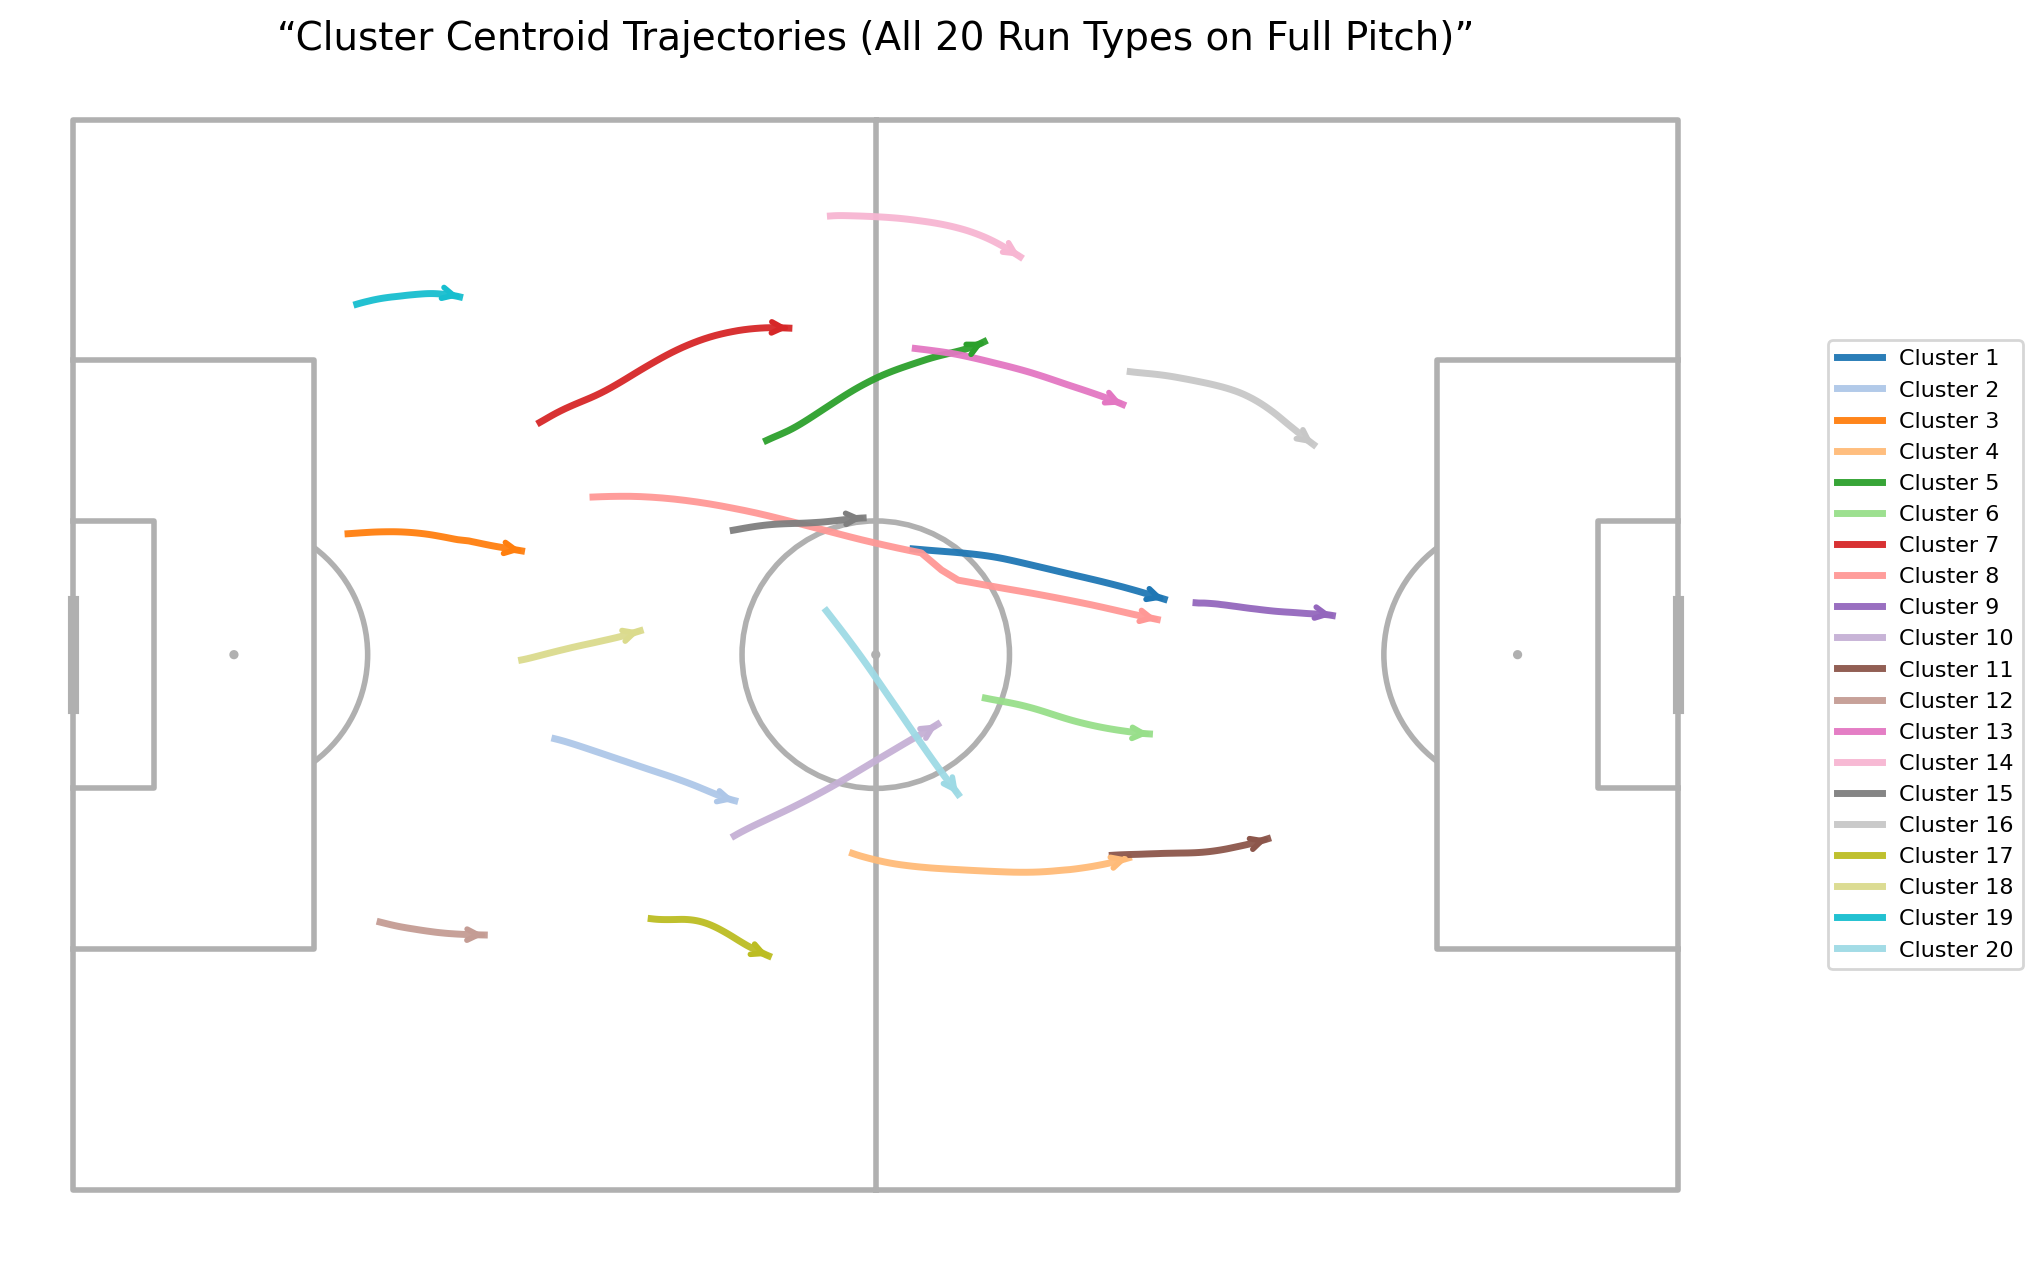

In [16]:
#Step 3 - Visualize Cluster Centroids on a Single Pitch

def plot_all_centroids_one_pitch(norm_runs, labels, pitch_length=105, pitch_width=68):

    clusters = np.unique(labels)
    cmap = plt.get_cmap('tab20')
    true_ratio = pitch_length / pitch_width
    fig_width = 10
    fig_height = fig_width / true_ratio

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Draw pitch
    pitch = Pitch(
        pitch_type='statsbomb',
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_zorder=1
    )
    pitch.draw(ax=ax)

    legend_handles = []

    # ---- PLOT EACH CLUSTER CENTROID ----
    for i, cid in enumerate(clusters):
        idx = np.where(labels == cid)[0]
        cluster_runs = [norm_runs[j] for j in idx]

        if len(cluster_runs) == 0:
            continue

        run_stack = np.stack(cluster_runs)
        centroid = np.mean(run_stack, axis=0)

        color = cmap(i % 20)

        h, = ax.plot(
            centroid[:, 0], centroid[:, 1],
            color=color, lw=2.5, alpha=0.95
        )
        legend_handles.append((h, f"Cluster {cid+1}"))

        # Direction arrow
        ax.annotate(
            "",
            xy=(centroid[-1, 0], centroid[-1, 1]),
            xytext=(centroid[-2, 0], centroid[-2, 1]),
            arrowprops=dict(arrowstyle="->", color=color, lw=2)
        )

    # ---- LEGEND ON RIGHT SIDE ----
    ax.legend(
        [h for h, _ in legend_handles],
        [lab for _, lab in legend_handles],
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=8
    )

    ax.set_title("“Cluster Centroid Trajectories (All 20 Run Types on Full Pitch)”", fontsize=14)
    plt.tight_layout()
    plt.show()


# ---- AUTO RUN ----
plot_all_centroids_one_pitch(
    norm_runs,
    labels,
    pitch_length=pitch_length,
    pitch_width=pitch_width
)


Goal 4: Define "runs" as periods in which an individual player spends above a certain velocity of your choosing. Explain your selection.

In [17]:
 #Step 4 – Cluster Summary

MAX_REALISTIC_SPEED = 12.0
cluster_counts = pd.Series(labels).value_counts().sort_index()

cluster_avg_speeds = []
for i in range(len(cluster_counts)):
    runs_in_cluster = [runs[j] for j in np.where(labels == i)[0]]
    run_speeds = []

    for run in runs_in_cluster:
        if len(run) < 2:
            continue
        dx = run['x'].diff().to_numpy()[1:]
        dy = run['y'].diff().to_numpy()[1:]
        dt = run['timestamp'].diff().dt.total_seconds().to_numpy()[1:]
        mask = dt > 0

        speed = np.sqrt(dx[mask]**2 + dy[mask]**2) / dt[mask]
        speed = speed[speed <= MAX_REALISTIC_SPEED]

        if len(speed) > 0:
            run_speeds.append(np.mean(speed))

    avg_speed = np.round(np.mean(run_speeds), 1) if run_speeds else 0
    cluster_avg_speeds.append(avg_speed)

cluster_summary = pd.DataFrame({
    'Cluster': np.arange(1, len(cluster_counts)+1),
    'Number of Runs': cluster_counts.values,
    'Average Speed (m/s)': cluster_avg_speeds
})

display(cluster_summary.style.hide(axis="index"))

Cluster,Number of Runs,Average Speed (m/s)
1,27,4.900000
2,16,4.700000
3,28,4.600000
4,20,5.100000
5,22,5.000000
6,30,4.800000
7,31,4.900000
8,23,5.500000
9,21,4.900000
10,25,5.000000
